Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ercankoseni_final.ipynb  new_coin.jpg  tura  yazı
Epoch 1/20
2/2 [==============================] - 2s 269ms/step - loss: 7.6186 - classification_loss: 0.7701 - position_loss: 6.8485 - classification_accuracy: 0.5625 - position_mean_squared_error: 6.8485 - val_loss: 1.6444 - val_classification_loss: 0.7681 - val_position_loss: 0.8764 - val_classification_accuracy: 0.4706 - val_position_mean_squared_error: 0.8764
Epoch 2/20
2/2 [==============================] - 0s 70ms/step - loss: 1.6356 - classification_loss: 0.8688 - position_loss: 0.7668 - classification_accuracy: 0.4219 - position_mean_squared_error: 0.7668 - val_loss: 0.9415 - val_classification_loss: 0.7082 - val_position_loss: 0.2333 - val_classification_accuracy: 0.4706 - val_position_mean_squared_error: 0.2333
Epoch 3/20
2/2 [==============================] - 0s 52ms/step - loss: 1.0515 - classifica

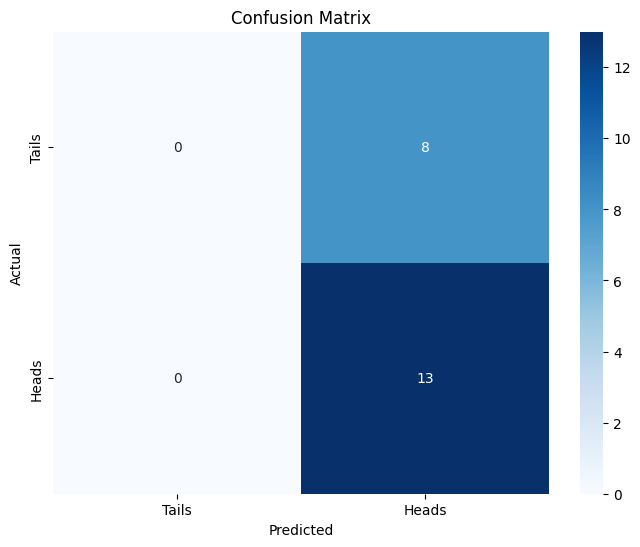

Accuracy: 61.90%
Precision: 61.90%
Recall: 100.00%
F1 Score: 76.47%
MSE (Position): 0.1008
1/1 [==============================] - 0s 174ms/step
Predicted Side: Heads, Predicted Position: [[0.49922177 0.55276614]]


In [9]:

from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/ysafinal'

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error
from tensorflow.keras.metrics import MeanSquaredError
import seaborn as sns
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = (128, 128)  # Resize images to 128x128 pixels

#dataset folders
# for checking please change the address of dataset, you can download the dataset from the github link, which I wrote in the report
yazi_folder = '/content/drive/My Drive/ysafinal/yazı/'
tura_folder = '/content/drive/My Drive/ysafinal/tura/'

# Function to preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img_gray = cv2.resize(img_gray, IMG_SIZE)
    return img_gray / 255.0  # Normalizing the image

# Function to load and preprocess images
def load_images(folder):
    images = []
    positions = []  # Store positions
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = preprocess_image(img_path)
        position = np.random.rand(2)

        images.append(img)
        positions.append(position)
    return np.array(images), np.array(positions)

# Loading and labeling images
yazi_images, yazi_positions = load_images(yazi_folder)
tura_images, tura_positions = load_images(tura_folder)


yazi_labels = np.ones(len(yazi_images))
tura_labels = np.zeros(len(tura_images))

images = np.concatenate((yazi_images, tura_images), axis=0)
labels = np.concatenate((yazi_labels, tura_labels), axis=0)
positions = np.concatenate((yazi_positions, tura_positions), axis=0)


X_train, X_test, y_train, y_test, pos_train, pos_test = train_test_split(images, labels, positions, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, *IMG_SIZE, 1)
X_test = X_test.reshape(-1, *IMG_SIZE, 1)


input_layer = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)


classification_output = Dense(1, activation='sigmoid', name='classification')(x)
position_output = Dense(2, activation='linear', name='position')(x)


model = Model(inputs=input_layer, outputs=[classification_output, position_output])


model.compile(
    optimizer='adam',
    loss={'classification': 'binary_crossentropy', 'position': 'mean_squared_error'},
    metrics={'classification': 'accuracy', 'position': MeanSquaredError()}
)



history = model.fit(
X_train, {'classification': y_train, 'position': pos_train},
epochs=20, validation_split=0.2, batch_size=32
)


evaluation = model.evaluate(X_test, {'classification': y_test, 'position': pos_test})
print(f'Test Accuracy (Classification): {evaluation[1] * 100:.2f}%')
print (f'Test MSE (Position): {evaluation[3]:.4f}')


y_pred, pos_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Tails', 'Heads'], yticklabels=['Tails', 'Heads'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)


mse_position = mean_squared_error(pos_test, pos_pred)


print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(f'MSE (Position): {mse_position:.4f}')

model.save('coin_drop_prediction_model.keras')

# new coin for predicting
def predict_new_coin(img_path):
    img = preprocess_image(img_path)
    img = img.reshape(-1, *IMG_SIZE, 1)
    classification, position = model.predict(img)
    coin_side = 'Heads' if classification > 0.5 else 'Tails'
    return coin_side, position
new_img_path = '/content/drive/My Drive/ysafinal/new_coin.jpg'
predicted_side, predicted_position = predict_new_coin(new_img_path)
print(f"Predicted Side: {predicted_side}, Predicted Position: {predicted_position}")
